## Liveness detection for Face recognition

We are tasked with distinguishing real faces vs spoofing face.
    
| <center>Real</center> | <center>Spoofing</center> |
|--------|------------|
| <img src="data/Detectedface/ClientFace/0013/0013_01_07_03_394.jpg" width="200"/>  |  <img src="data/Detectedface/ImposterFace/0002/0002_01_03_02_81.jpg" width="200"/> |

How are we gonna do this? What is the difference between image of a real face and image of a fake one? What model can recognize the difference?

In [3]:
# import stuff we need
import cv2
import tensorflow as tf
import keras
from keras.preprocessing.image import load_img, save_img, img_to_array
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import random

tf.enable_eager_execution()
tf.__version__

'1.14.0'

In [29]:
x = [[2.]]
m = tf.matmul(x, x)
print(m)
print("hello, {}".format(m))

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)
hello, [[4.]]


Here we enable `eager execution` for easier debugging. What is `eager execution`?

>TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, without building graphs: operations return concrete values instead of constructing a computational graph to run later. This makes it easy to get started with TensorFlow and debug models, and it reduces boilerplate as well.
Eager execution is a flexible machine learning platform for research and experimentation, providing:
* An intuitive interface—Structure your code naturally and use Python data structures. Quickly iterate on small models and small data.
* Easier debugging—Call ops directly to inspect running models and test changes. Use standard Python debugging tools for immediate error reporting.
* Natural control flow—Use Python control flow instead of graph control flow, simplifying the specification of dynamic models.

If it's that great why don't people use it all the time?
It's slow compared to using graph.

Let's check if we can find some differences between real and spoofing face images.

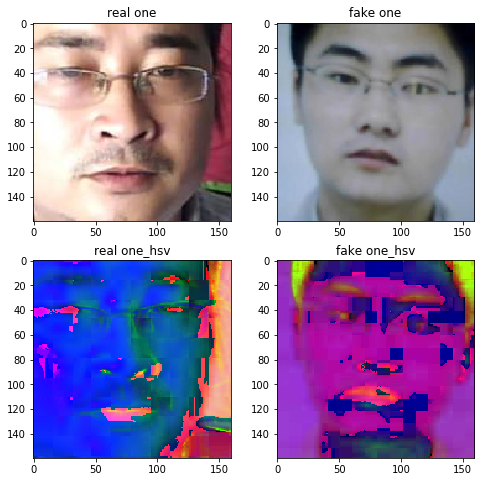

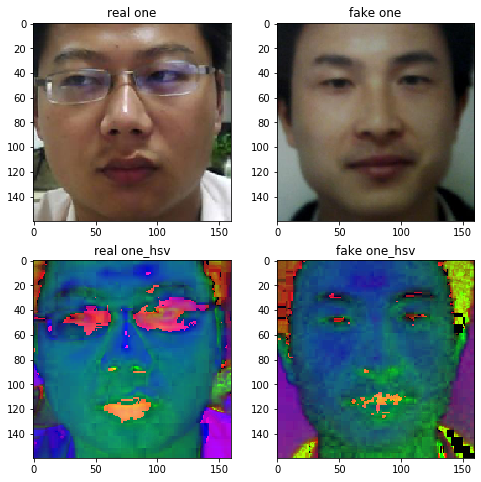

In [19]:
def show_image_pair(img1, img2, title1 = "Image 1", title2 = "Image 2"):
    img1_hsv = img1.convert('HSV')
    img2_hsv = img2.convert('HSV')
    
    plt.figure(figsize=(8, 8))
    plt.subplot(221)
    plt.imshow(img1)
    plt.title(title1)

    plt.subplot(222)
    plt.imshow(img2)
    plt.title(title2)
    
    plt.subplot(223)
    plt.imshow(img1_hsv)
    plt.title(title1 + '_hsv')
    
    plt.subplot(224)
    plt.imshow(img2_hsv)
    plt.title(title2 + '_hsv')

real_image = 'data/Detectedface/ClientFace/0013/0013_01_07_03_394.jpg'
spf_image = 'data/Detectedface/ImposterFace/0002/0002_01_03_02_81.jpg'

real_img = load_img(real_image, target_size=(160, 160))
spf_img = load_img(spf_image, target_size=(160, 160))

show_image_pair(real_img, spf_img, 'real one', 'fake one')

# try other pair
real_image = 'data/Detectedface/ClientFace/0007/0007_01_00_02_297.jpg'
spf_image = 'data/Detectedface/ImposterFace/0001/0001_00_04_03_235.jpg'

real_img = load_img(real_image, target_size=(160, 160))
spf_img = load_img(spf_image, target_size=(160, 160))

show_image_pair(real_img, spf_img, 'real one', 'fake one')

Frankly, It's really hard to spot the difference. We can bet our luck on the magic of Deep Learning.

Let's prepare the data pipline for the model:

In [20]:
# Build dataset using tf.data
data_root = pathlib.Path('data/Detectedface/')
print(data_root)

for item in data_root.iterdir():
    print(item)
    
import random
all_image_paths = list(data_root.glob('*/*/*.jpg'))
all_image_paths = [str(path) for path in all_image_paths]
random.shuffle(all_image_paths)

image_count = len(all_image_paths)
image_count

data/Detectedface
data/Detectedface/imposter_test_face.txt
data/Detectedface/client_train_face.txt
data/Detectedface/.DS_Store
data/Detectedface/ClientFace
data/Detectedface/client_test_face.txt
data/Detectedface/readme.txt
data/Detectedface/imposter_train_face.txt
data/Detectedface/ImposterFace


12614

In [21]:
all_image_paths[:10]

['data/Detectedface/ImposterFace/0009/0009_01_03_03_317.jpg',
 'data/Detectedface/ClientFace/0012/0012_01_07_03_2.jpg',
 'data/Detectedface/ImposterFace/0005/0005_00_02_03_439.jpg',
 'data/Detectedface/ImposterFace/0015/0015_01_01_03_267.jpg',
 'data/Detectedface/ClientFace/0006/0006_00_06_03_182.jpg',
 'data/Detectedface/ImposterFace/0007/0007_01_04_03_380.jpg',
 'data/Detectedface/ImposterFace/0010/0010_01_02_03_32.jpg',
 'data/Detectedface/ImposterFace/0003/0003_01_02_03_377.jpg',
 'data/Detectedface/ImposterFace/0006/0006_00_00_01_175.jpg',
 'data/Detectedface/ClientFace/0010/0010_01_05_03_304.jpg']

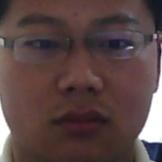

ClientFace/0007/0007_01_00_01_284.jpg



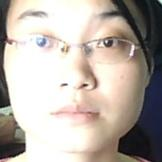

ClientFace/0004/0004_01_06_03_4.jpg



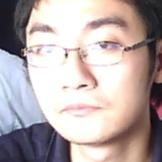

ClientFace/0012/0012_01_07_03_124.jpg



In [22]:
import IPython.display as display

for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path))
    image_rel = pathlib.Path(image_path).relative_to(data_root)
    print(image_rel)
    print()

In [23]:
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
label_names

['ClientFace', 'ImposterFace']

In [24]:
label_to_index = dict((name, index) for index,name in enumerate(label_names))
label_to_index

{'ClientFace': 0, 'ImposterFace': 1}

Get the label list of all images in the dataset

In [25]:
all_image_labels = [label_to_index[pathlib.Path(path).parent.parent.name]
                    for path in all_image_paths]

print("First 10 labels indices: ", all_image_labels[:10])
print("First 10 image: ", all_image_paths[:10])

First 10 labels indices:  [1, 0, 1, 1, 0, 1, 1, 1, 1, 0]
First 10 image:  ['data/Detectedface/ImposterFace/0009/0009_01_03_03_317.jpg', 'data/Detectedface/ClientFace/0012/0012_01_07_03_2.jpg', 'data/Detectedface/ImposterFace/0005/0005_00_02_03_439.jpg', 'data/Detectedface/ImposterFace/0015/0015_01_01_03_267.jpg', 'data/Detectedface/ClientFace/0006/0006_00_06_03_182.jpg', 'data/Detectedface/ImposterFace/0007/0007_01_04_03_380.jpg', 'data/Detectedface/ImposterFace/0010/0010_01_02_03_32.jpg', 'data/Detectedface/ImposterFace/0003/0003_01_02_03_377.jpg', 'data/Detectedface/ImposterFace/0006/0006_00_00_01_175.jpg', 'data/Detectedface/ClientFace/0010/0010_01_05_03_304.jpg']


Helper function to load images from disk:

In [26]:
def preprocess_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [192, 192])
    image /= 255.0  # normalize to [0,1] range
    print(image)
    return image

def load_and_preprocess_image(path):
    image = tf.read_file(path)
    return preprocess_image(image)

Tensor("truediv_2:0", shape=(192, 192, 3), dtype=float32)



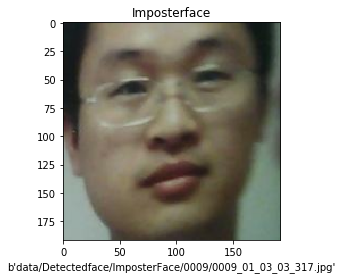

In [33]:
# test the helper functions

import matplotlib.pyplot as plt

img_path = all_image_paths[0]
label = all_image_labels[0]

with tf.Session() as sess:
    image = sess.run(load_and_preprocess_image(img_path))

# we are in eager execution mode so we don't really need session
# we can just run the following code to do the job
# image = load_and_preprocess_image(img_path)

plt.imshow(image)
plt.grid(False)
plt.xlabel(img_path.encode('utf-8'))
plt.title(label_names[label].title())
print()

In [34]:
# Tensor that contain paths to the images
path_ds = tf.data.Dataset.from_tensor_slices(all_image_paths)

print('shape: ', repr(path_ds.output_shapes))
print('type: ', path_ds.output_types)
print()
print(path_ds)

W0718 14:03:13.940099 4390188480 deprecation.py:323] From <ipython-input-34-a9c58bffc333>:4: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.
W0718 14:03:13.941006 4390188480 deprecation.py:323] From <ipython-input-34-a9c58bffc333>:5: DatasetV1.output_types (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_types(dataset)`.


shape:  TensorShape([])
type:  <dtype: 'string'>

<DatasetV1Adapter shapes: (), types: tf.string>


In [35]:
# Load the images using the path tensor
image_ds = path_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

Tensor("truediv:0", shape=(192, 192, 3), dtype=float32)


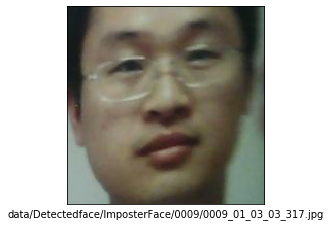

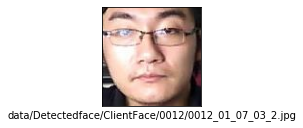

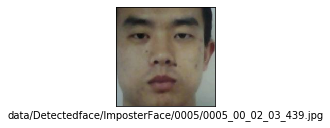

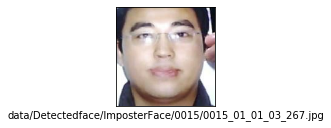

In [36]:
# test the image image dataset

plt.figure(figsize=(8,8))
for n,image in enumerate(image_ds.take(4)):
    plt.subplot(2,2,n+1)
    plt.imshow(image)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(all_image_paths[n])
    plt.show()

In [37]:
label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(all_image_labels, tf.int64))

for label in label_ds.take(5):
    print(label_names[label.numpy()])

ImposterFace
ClientFace
ImposterFace
ImposterFace
ClientFace


In [38]:
image_label_ds = tf.data.Dataset.zip((image_ds, label_ds))

print(image_label_ds)

<DatasetV1Adapter shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


In [18]:
BATCH_SIZE = 128

# Setting a shuffle buffer size as large as the dataset ensures that the data is
# completely shuffled.
train_ds = image_label_ds.take(int(0.7 * image_count))
val_ds = image_label_ds.skip(int(0.7 * image_count))

train_ds = train_ds.cache(filename='./cache.tf-data-train')
train_ds = train_ds.shuffle(buffer_size=image_count)
train_ds = train_ds.repeat()
train_ds = train_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_ds = val_ds.cache(filename='./cache.tf-data-val')
val_ds = val_ds.shuffle(buffer_size=image_count)
val_ds = val_ds.repeat()
val_ds = val_ds.batch(BATCH_SIZE)
# `prefetch` lets the dataset fetch batches, in the background while the model is training.
val_ds = val_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds

<DatasetV1Adapter shapes: ((?, 192, 192, 3), (?,)), types: (tf.float32, tf.int64)>

Change the range of image tensor to [-1 1]

In [20]:
def change_range(image,label):
    return 2*image-1, label

train_ds = train_ds.map(change_range)
val_ds = val_ds.map(change_range)

In [21]:
# The dataset may take a few seconds to start, as it fills its shuffle buffer.
image_batch, label_batch = next(iter(train_ds))

In [22]:
#feature_map_batch = mobile_net(image_batch)
#print(feature_map_batch.shape)

In [23]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3, 3), padding='same',
                 input_shape=(192, 192, 3)))

# Construct your model here


In [24]:
logit_batch = model(image_batch).numpy()

print("min logit:", logit_batch.min())
print("max logit:", logit_batch.max())
print()

print("Shape:", logit_batch.shape)

min logit: 0.45419058
max logit: 0.5458094

Shape: (128, 2)


In [25]:
model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=["accuracy"])

In [ ]:
model.summary()

In [27]:
steps_per_epoch=tf.ceil(len(all_image_paths)/BATCH_SIZE).numpy()
steps_per_epoch

99.0

In [28]:
model.fit(train_ds, epochs=5, steps_per_epoch=70, validation_data=val_ds, validation_steps=30)

Epoch 1/5


W0705 12:42:59.822404 4544161216 deprecation.py:323] From /Volumes/Data/ethan/.env_tf110_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


70/70 [==============================] - 161s 2s/step - loss: 0.4761 - acc: 0.7720 - val_loss: 0.2424 - val_acc: 0.9078
Epoch 2/5
70/70 [==============================] - 128s 2s/step - loss: 0.2000 - acc: 0.9267 - val_loss: 0.1518 - val_acc: 0.9492
Epoch 3/5
70/70 [==============================] - 128s 2s/step - loss: 0.1271 - acc: 0.9526 - val_loss: 0.1154 - val_acc: 0.9565
Epoch 4/5
70/70 [==============================] - 127s 2s/step - loss: 0.1375 - acc: 0.9516 - val_loss: 0.0965 - val_acc: 0.9646
Epoch 5/5
70/70 [==============================] - 124s 2s/step - loss: 0.1123 - acc: 0.9598 - val_loss: 0.0977 - val_acc: 0.9716


### Assignment

* Collect some image of real and spoofing images
* Use your trained model to classify those image
* Does your model perform good or bad? it it's bad, how can we improve it?